In [2]:
## import libraries
%load_ext autoreload
%autoreload 2
import utilities as util
import os
import reedsolo
import random
import time
import matplotlib.pyplot as plt

In [60]:
## set variables
path = os.path.relpath("C:\\Users\\justi\\Documents\\DBLCompBioGroup12\\Data\\ceze.pdf")
seed = 7
extra = 1.1
max_homopolymer = 3
DNA_filename = "DNA_strands.txt"
collapsed_filename = "sequenced.txt"
#Whether or not to correct the droplets using RS
correct = True

In [63]:
def Encode(file_path, seed, extra = 1.05, max_homopolymer = 3) -> list:
    """ Read and encode a file using the luby transform, returning a list of DNA sequences
    INPUT:
    file_path: path to the file to be encoded
    seed:  seed for the randomization of data
    extra: amount of extra droplets compared to data (default 5%, so 1.05)
    max_homopolymer: maximum length of homopolymer sequences allowed (default 3)
    OUTPUT:
    droplets: list of DNA sequences
    """
    # first read file
    data = util.OpenFile(file_path)
    # make bytearray from data
    data = bytearray(data)
    # randomize first
    data = util.RandomizeMessage(data, seed)
    # data needs to be converted to string for segmentation
    data = util.Bytearray2Binary(data)
    # add padding and segment
    data = util.Segment(data)
    # now the luby transform needs to be applied
    

    total_segments = len(data)
    print(total_segments)
    distribution_size = total_segments 
    # first convert segments to bytearrays
    data_bytearray = [util.Binary2Bytearray(segment) for segment in data]
    
    # create a Pseudo random number generator 
    prng = random.Random()
    seeds_lfsr = util.LFSR() #starting an lfsr with a certain state and a polynomial for 32bits.
    nr_droplets_probablities = util.RobustSoliton(distribution_size, 0.001, 0.025)
    droplets = []
    droplets_required = int(extra*total_segments)
    while len(droplets) < droplets_required:
        # generate a seed for droplet making
        seed = next(seeds_lfsr)
        # create droplet
        current_drop = util.MakeDroplet(data_bytearray, seed, prng, nr_droplets_probablities)
        # convert drop to string and then DNA
        current_drop = util.Binary2DNA(util.Bytearray2Binary(current_drop))
        # check biochemical requirements and append to list of droplets if ok
        if util.CheckBiochemicalRequirements(current_drop, max_homopolymer):
            droplets.append(current_drop)
    
    ##make metadata-strands
    metastrand = util.CreateMetaStrand(total_segments)
    
    for x in range(3): # now 3 for adding it in 3 times
        droplets.append(metastrand)
    
    return droplets

In [64]:
encoded = Encode(path, seed, extra, max_homopolymer)

37310


In [66]:
f = open(DNA_filename, "w")
for i in encoded:
    f.write(i + "\n")
f.close()


In [65]:
len(encoded)

41044

# DNA SYNTHESIS, STORAGE AND SEQUENCING

# DECODING

In [67]:
with open(collapsed_filename, 'r') as f:
    dropletlist = [line.rstrip('\n') for line in f]

#total_segments = 15399 # moet geen variabele meer zijn
n=0
#check if all the droplets meet our requirements otherwise don't add them to the list of OKdroplets
metadata = []
OKdroplets = []
for strand in dropletlist:
    if util.CheckBiochemicalRequirements(strand):
        if util.CheckOligoLength(strand):
            if strand[:16] == "ACGTACGTACGTACGT":
                metadata.append(strand)
            else:
                OKdroplets.append(strand)
total_segments_list = [util.DecodeMetaStrand(metastrand) for metastrand in metadata]
total_segments = max(set(total_segments_list), key = total_segments_list.count)
print(total_segments)
simplified_droplets = []
corrected_droplets = []
rsc = reedsolo.RSCodec(2)
for strand in OKdroplets:
    binary_strand = util.DNA2Binary(strand)
    bytearray_strand = util.Binary2Bytearray(binary_strand)
#convert the list of strings to a bytearray 
    if rsc.check(bytearray_strand)[0]:
        droplet_seed = int(binary_strand[0:32], 2)
        segment_amount, segment_indices = util.RecoverSeed(droplet_seed, total_segments)
        payload = binary_strand[32:288]
        simplified_droplets.append((segment_indices, payload))
        n+=1
    else:
        try:
            binary_strand = util.Bytearray2Binary(rsc.decode(bytearray_strand)[0])
            droplet_seed = int(binary_strand[0:32], 2)
            segment_amount, segment_indices = util.RecoverSeed(droplet_seed, total_segments)
            payload = binary_strand[32:288]
            corrected_droplets.append((segment_indices, payload))
        except Exception:
            pass
simplified_droplets += corrected_droplets
        
print(n,len(OKdroplets),len(dropletlist))
#if the strand is correct according to reed-solomon, 
#make a list including the segment indices of the droplet and #their combined XOR

37310
37813 39531 41003


In [68]:
output_data = {}
input_data = simplified_droplets
newsolves = 1
while newsolves > 0:
    input_data, output_data, newsolves = util.Decode(input_data, output_data)


In [69]:
len(output_data)

500

In [30]:
if len(output_data)==total_segments:
    solution = ''.join([output_data[x] for x in range(15399)])
    solution = util.RemovePadding(solution)
    solution = util.RandomizeMessage(util.Binary2Bytearray(solution))
else:
    solution = bytearray(0)
    print('solution could not be reached, use another more robust method' + str(len(output_data)))

Run this code to write the recovered file, change the filename as you please. 

In [32]:
with open("recovered_ceze.pdf", "wb") as file:
    file.write(solution)


In [31]:
solution

bytearray(b'%PDF-1.5\n%\xbf\xf7\xa2\xfe\n32 0 obj\n<< /Linearized 1 /L 492764 /H [ 1489 227 ] /O 36 /E 83367 /N 7 /T 492303 >>\nendobj\n                                                                                                            \n33 0 obj\n<< /Type /XRef /Length 87 /Filter /FlateDecode /DecodeParms << /Columns 5 /Predictor 12 >> /W [ 1 3 1 ] /Index [ 32 110 ] /Info 24 0 R /Root 34 0 R /Size 142 /Prev 492304                /ID [<437d01ecf275a2cb3c8da28c782cc343><061a413d5a0fbe682de8d129702e05ab>] >>\nstream\nx\x9ccbd`\xe0g`b``8\t"Y\x9d\xc1\xecm \x92\xf11\x98l\x06\x91:: \x92y?\x88\xb4\x9c\x01"\xd5\xd5A\xa4\xed;\x10\xa9q\x06,+\x00$\x19\x99uAl\x160\xa9\xaf\x02\x16\xd7g`b\xfc\x7f\xf2\x06\xd8d\x06\xc6Qr\x94\xc4O\x02\x00\xb5\xf7\x0ck\nendstream\nendobj\n                                                                                                                                                                                                                                   

# Visualizing/Improving decoding

3 30


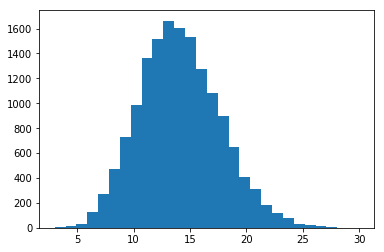

In [10]:
seg_dic = {x:0 for x in range(15399)}
for x in simplified_droplets:
    for ind in x[0]:
        seg_dic[ind] += 1

plt.hist(seg_dic.values(), bins=28)
print(min(seg_dic.values()),max(seg_dic.values()))

In [11]:
# nr_solves = []
# for i in range(len(simplified_droplets)):
#     output_data = {}
#     input_data = simplified_droplets[0:i]
#     newsolves = 1
#     while newsolves > 0:
#         input_data, output_data, newsolves = util.Decode(input_data, output_data)
#     nr_solves.append(len(output_data))

In [12]:
# x=range(len(simplified_droplets))
# plt.plot(x, nr_solves)

In [13]:
count=0
ind_unsolved = []
for x in input_data:
    for ind in x[0]:
        if ind not in ind_unsolved:
            ind_unsolved.append(ind)

ind_unsolved.sort()
    

In [14]:
ind_unsolved

[]